# Load the data

In [238]:
#Processing
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import skew
import gc
import seaborn as sns
#Plotting
import matplotlib.pyplot as plt

#Models
import xgboost as xgb
from xgboost import XGBClassifier

In [178]:
train = pd.read_csv('data/challenge2_train.csv')
test = pd.read_csv('data/challenge2_test.csv')

# Exploratory Data Analysis

## Get an overview of the data

First, we want to know what kind of data we are dealing with.

In [179]:
train.columns

Index(['id', 'target', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18',
       'f19', 'f20', 'f21', 'f22', 'f23', 'f24'],
      dtype='object')

In [180]:
test.columns

Index(['id', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24'],
      dtype='object')

In [181]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50000 non-null  int64  
 1   target  50000 non-null  int64  
 2   f0      45122 non-null  float64
 3   f1      50000 non-null  int64  
 4   f2      48816 non-null  float64
 5   f3      49677 non-null  float64
 6   f4      46621 non-null  object 
 7   f5      26130 non-null  float64
 8   f6      46648 non-null  float64
 9   f7      49517 non-null  float64
 10  f8      48540 non-null  object 
 11  f9      49497 non-null  float64
 12  f10     28585 non-null  float64
 13  f11     49894 non-null  float64
 14  f12     48487 non-null  object 
 15  f13     49497 non-null  float64
 16  f14     29937 non-null  float64
 17  f15     49057 non-null  float64
 18  f16     49020 non-null  float64
 19  f17     48630 non-null  object 
 20  f18     48749 non-null  float64
 21  f19     45121 non-null  float64
 22

We see from the column names that both the training and test set includes IDs. As the data is anonymized and the IDs are unique, we do not want them to affect the training, and therefore drop them for now.

We also want to separate the targets from the samples during training so we can use them for validation.

In [290]:
X_train = train.drop(["id", "target"], axis=1)
Y_train = train["target"].values

In [183]:
X_test = test.drop(["id"], axis=1)

Let's explore the shape and content of the data.

In [184]:
X_train.head()

f0  f1      f2    f3   f4    f5    f6    f7 f8   f9  ...   f15   f16  \
0  1013.1   0  5.0190  26.1  bbd  11.1  33.0  11.0  m  0.0  ...  19.0  27.8   
1  1010.2   1  5.0142  10.4    n   NaN  46.0  17.0  k  0.0  ...  22.0  12.7   
2  1014.4   2  5.0280  12.3  xnx   NaN  31.0  13.0  c  1.0  ...   9.0  13.0   
3  1019.2   3  5.0335  23.0   nx  11.6  41.0   9.0  i  0.0  ...  17.0  32.3   
4  1027.6   4  5.0129   7.3    d   7.3  28.0  15.0  h  1.0  ...  13.0  13.7   

   f17   f18     f19  f20  f21   f22   f23   f24  
0  bbd   6.0  1008.9  1.0   nd  17.4  61.0  63.0  
1    n  12.0  1012.4  5.0   nx   6.8  55.0  80.0  
2  nnd   7.0  1016.1  NaN   nx  10.1  61.0  70.0  
3   nx  10.0  1016.6  1.0  dnd  14.4   NaN  40.0  
4  dnd   7.0  1024.4  7.0  dbd   6.8  47.0  92.0  

[5 rows x 25 columns]

In [185]:
X_train.shape

(50000, 25)

In [186]:
Y_train.shape

(50000,)

In [187]:
X_test.shape

(50000, 25)

From `.info()` and `.head()`, we can see that some of the features include categorical data. We want to figure out how many categories each of these feature include.

In [188]:
X_train['f4'].describe()

count     46621
unique       16
top           x
freq       3410
Name: f4, dtype: object

In [189]:
X_train['f8'].describe()

count     48540
unique       15
top           n
freq       5845
Name: f8, dtype: object

In [190]:
X_train['f17'].describe()

count     48630
unique       16
top          nd
freq       3762
Name: f17, dtype: object

In [191]:
X_train['f21'].describe()

count     46416
unique       16
top           b
freq       3996
Name: f21, dtype: object

Seems like most of them have 16 unique categories, but f8 has 15. It might be that f8 also has 16 categories, but only 15 of them are observed in the training data. This implies that unseen categories can show up during prediction, and should be handled.

One of the features, f12, consists of hex values:

In [192]:
X_train['f12'].head()

0    be42001f3
1    3aad93cab
2    90116a97d
3    dc4ee566b
4    f09cc205f
Name: f12, dtype: object

It is also worth noting that f9 values are binary. That means this feature represents a variable which is either true or false:

In [193]:
X_train['f9'].head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: f9, dtype: float64

Let's define which columns are categorical, hex valued and binary so we can remember it for later.

In [277]:
# Define which columns include categorical data
cat_cols = ['f4', 'f8', 'f17', 'f21']

# Columns containing hex values
hex_col = 'f12'

bin_col = 'f9'

## Unique values
How many unique values are there for each value in the data?

In [194]:
X_train.nunique(axis=0)

f0      505
f1       49
f2      413
f3      421
f4       16
f5      143
f6       62
f7       41
f8       15
f9        2
f10     278
f11     478
f12    1206
f13     486
f14      10
f15      41
f16     476
f17      16
f18      14
f19     495
f20      10
f21      16
f22     372
f23      30
f24     100
dtype: int64

## Null values
We want to see how many null variables there are in each column. First, a sum of all null values in each column is displayed, then they are plotted for each column.

In [195]:
X_train.isnull().sum()

f0      4878
f1         0
f2      1184
f3       323
f4      3379
f5     23870
f6      3352
f7       483
f8      1460
f9       503
f10    21415
f11      106
f12     1513
f13      503
f14    20063
f15      943
f16      980
f17     1370
f18     1251
f19     4879
f20    18755
f21     3584
f22      254
f23    24840
f24      602
dtype: int64

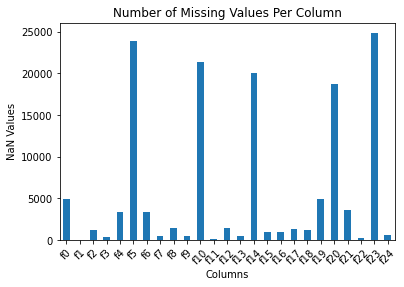

In [196]:
# plot missing data:
X_train.isnull().sum().plot(kind='bar')
# Add a title and show the plot.
plt.title('Number of Missing Values Per Column')
# Create tick mark labels on the Y axis and rotate them.
plt.xticks(rotation = 45)
# Create X axis label.
plt.xlabel("Columns")
# Create Y axis label.
plt.ylabel("NaN Values");

## Statistical analysis

In [197]:
X_train.describe()

f0           f1            f2            f3            f5  \
count  45122.000000  50000.00000  48816.000000  49677.000000  26130.000000   
mean    1017.678647     23.49612      5.018887     16.998782      7.628550   
std        7.130390     14.01738      0.007177      6.520973      3.776794   
min      982.000000      0.00000      4.998000     -6.200000      0.000000   
25%     1013.000000     11.00000      5.014000     12.300000      4.900000   
50%     1017.600000     23.00000      5.019100     16.700000      8.500000   
75%     1022.500000     35.00000      5.024100     21.600000     10.600000   
max     1040.900000     48.00000      5.045800     39.100000     14.300000   

                 f6            f7            f9           f10          f11  \
count  46648.000000  49517.000000  49497.000000  28585.000000  49894.00000   
mean      40.050999     14.000848      0.222862      5.463607     23.23301   
std       13.655620      8.936280      0.416171      4.251483      7.15277   
min        7.000000      0.000000      0.000000      0.000000     -4.10000   
25%       31.000000      7.000000      0.000000      2.600000     17.90000   
50%       39.000000     13.000000      0.000000      4.800000     22.60000   
75%       48.000000     19.000000      0.000000      7.400000     28.30000   
max      130.000000     87.000000      1.000000    145.000000     46.80000   

                f13           f14           f15           f16           f18  \
count  49497.000000  29937.000000  49057.000000  49020.000000  48749.000000   
mean       2.379215      4.508668     18.686630     21.683570      7.305524   
std        8.795403      2.717503      8.842879      6.970918      3.546719   
min        0.000000      0.000000      0.000000     -5.100000      0.000000   
25%        0.000000      2.000000     13.000000     16.600000      5.000000   
50%        0.000000      5.000000     19.000000     21.100000      7.000000   
75%        0.800000      7.000000     24.000000     26.500000     10.000000   
max      371.000000      9.000000     87.000000     46.100000     13.000000   

                f19           f20           f22           f23           f24  
count  45121.000000  31245.000000  49746.000000  25160.000000  49398.000000  
mean    1015.285913      4.428837     12.191203     52.013712     68.806470  
std        7.057875      2.884968      6.414481      8.323467     19.024988  
min      978.200000      0.000000     -8.500000     37.000000      1.000000  
25%     1010.500000      1.000000      7.600000     45.000000     57.000000  
50%     1015.300000      5.000000     12.000000     52.000000     70.000000  
75%     1020.100000      7.000000     16.900000     59.000000     83.000000  
max     1038.500000      9.000000     33.900000     66.000000    100.000000

Some noteable things to observe:
- f2 has a very low standard deviation, which means its values are almost the same for every sample. We can either drop this as a feature, or take the logarithm? This feature has missing values, making it easy to impute them.
- f6 has a high standard deviation
- many features has 0 as the minimum value - could be a placeholder for a missing value or human error?
- Several of the features have negative minimum values - is this an error? We will look at those features soon by plotting histograms of all values in e.g. f11 and f3
- Some features are actually integers

## Visualize the data

### Plot of f11

<AxesSubplot:ylabel='Frequency'>

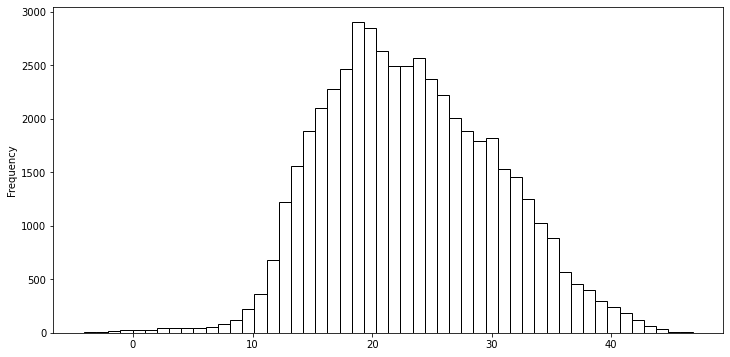

In [198]:
X_train['f11'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='white',edgecolor='black')

In [199]:
below_0_f11 = X_train['f11'].apply(lambda x: x < 0).sum()
below_0_f11

47

In [200]:
X_train['f15'].apply(lambda x: x == 0).sum()

404

In [201]:
# Amount of samples below zero
below_0_f11/(50000-X_train['f11'].isnull().sum())

0.0009419970337114683

### Plot of f3

<AxesSubplot:ylabel='Frequency'>

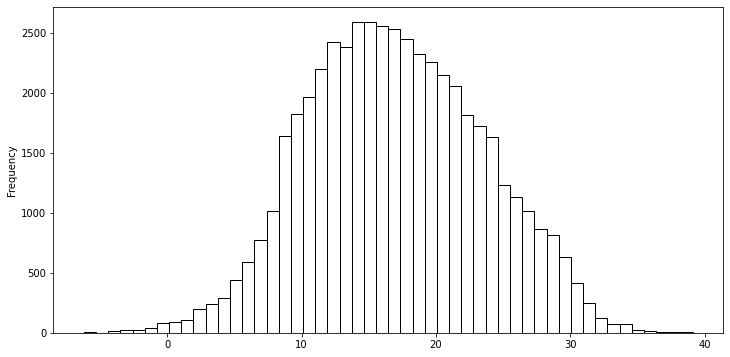

In [202]:
X_train['f3'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='white',edgecolor='black')

In [203]:
below_0_f3 = X_train['f3'].apply(lambda x: x < 0).sum()
below_0_f3

167

In [204]:
# Amount of samples below zero
below_0_f3/(50000-X_train['f3'].isnull().sum())

0.0033617166898162127

### Plot the mean

Let's plot the mean of each feature:

<AxesSubplot:>

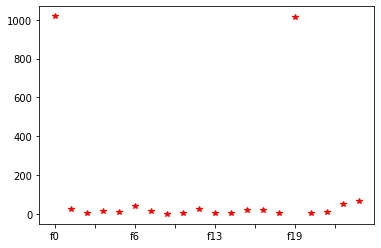

In [205]:
X_train.mean().plot(style='*', color='red')

Most of them are in the same range, except for f0 and f19. Let's remove them to better look at the others.

<AxesSubplot:>

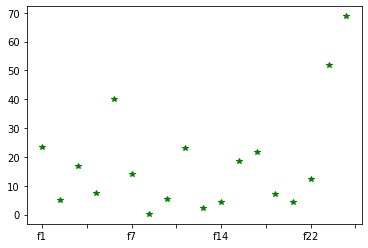

In [206]:
X_train.drop(['f0', 'f19'], axis=1).mean().plot(style='*', color='green')

### Correlations between variables

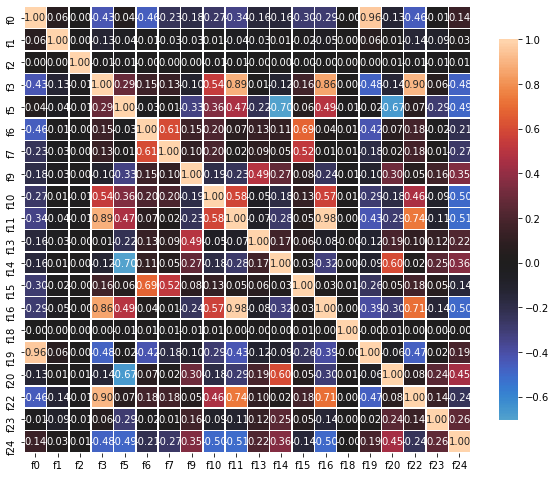

In [207]:
correlations = X_train.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
        square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

This table has some interesting information. Many of the features are correlated, as presented in this list:

- **f0** - **f19**
- **f3** - f11, f16, **f22**
- f5 - f14, f20
- f6 - f7, f15
- f7 - f15
- f9 - f13
- **f11** - **f16**, f22, f24
- f14 - f20
- f16 - f22

The bold features are either highly positively or highly negativley correlated. The features f0 and f19, f3 and f22, and f11 and f16 are have correlation of 0.9 or above. This implies that the features are redundant of each other, and might cause overfitting.

Lets create scatterplots of all the features, and highlight the ones with the highest correlations: 

### Scatterplots of features

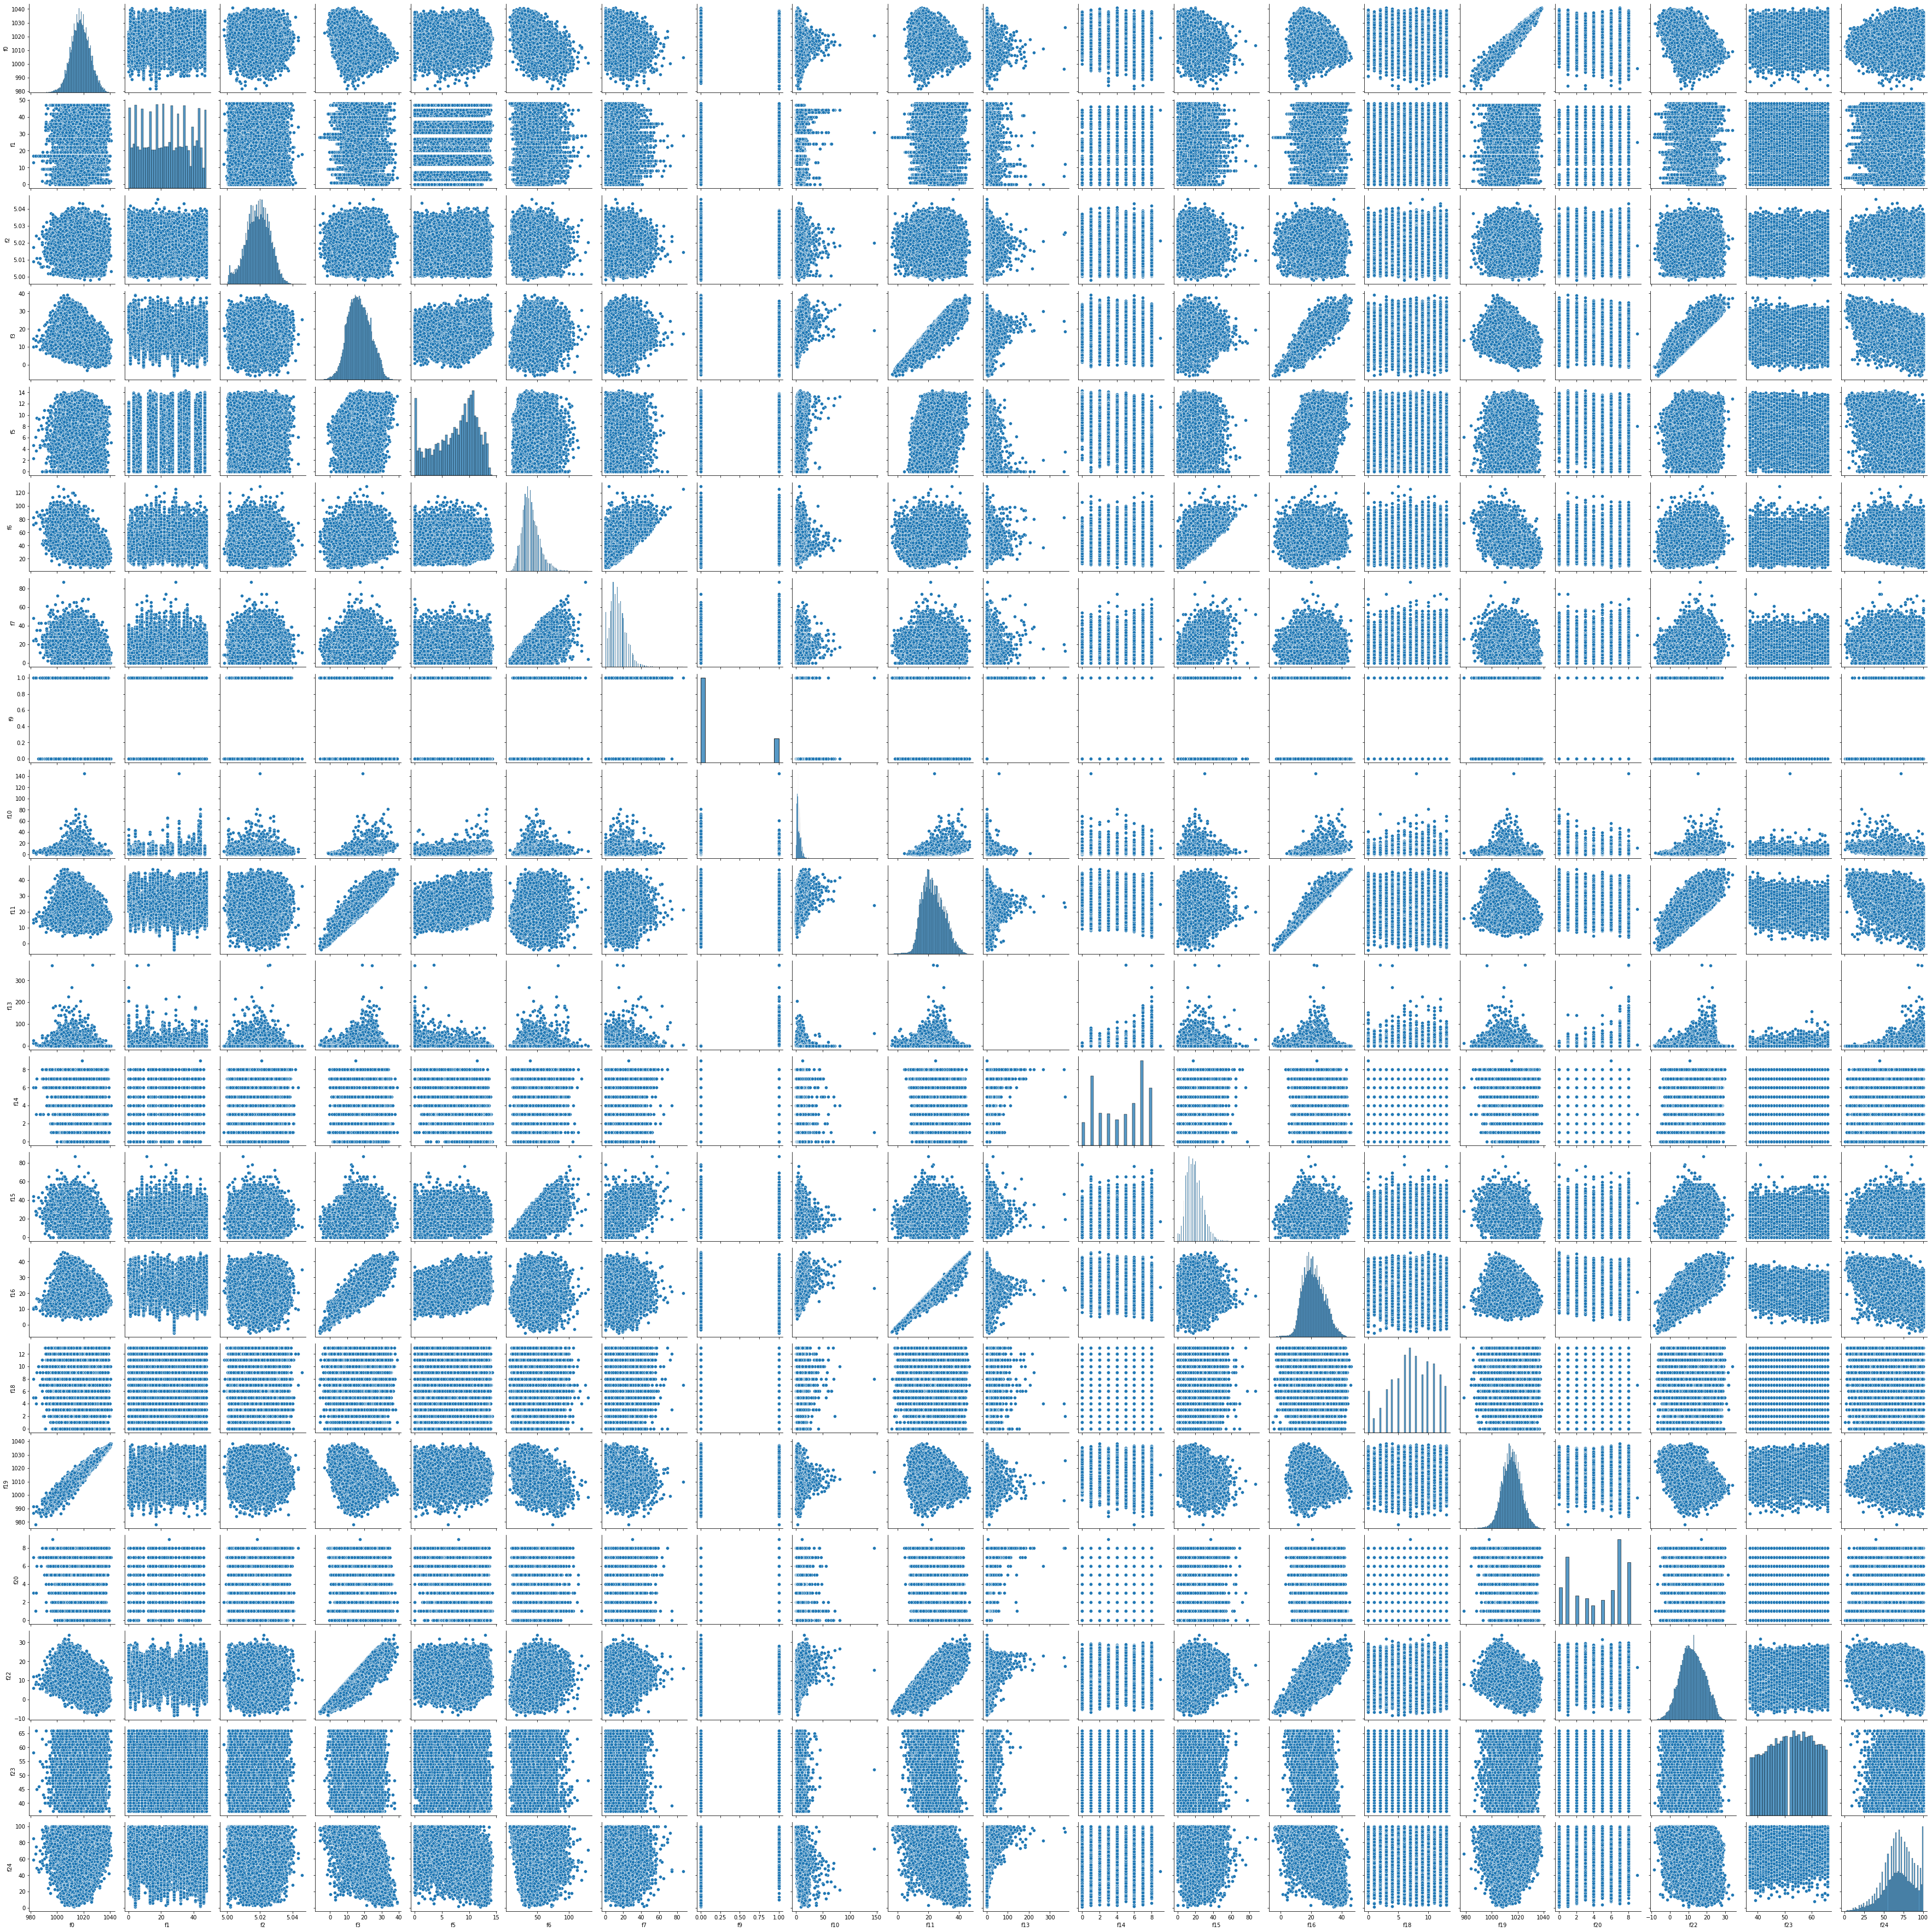

In [208]:
sns.pairplot(X_train)

### Scatterplots of highly correlated features

<AxesSubplot:xlabel='f0', ylabel='f19'>

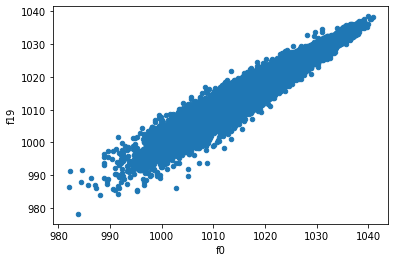

In [209]:
X_train.plot(kind='scatter', x='f0', y='f19')

<AxesSubplot:xlabel='f3', ylabel='f22'>

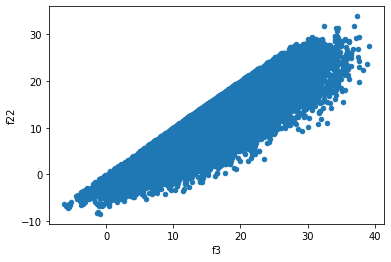

In [210]:
X_train.plot(kind='scatter', x='f3', y='f22')

<AxesSubplot:xlabel='f11', ylabel='f16'>

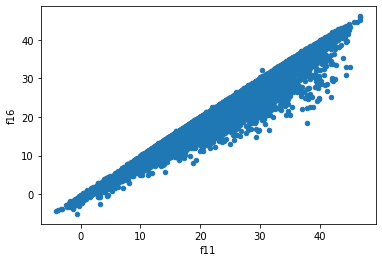

In [211]:
X_train.plot(kind='scatter', x='f11', y='f16')

For decision tree methods and boosting methods like XGBoost, however, multicollinearity between features does not affect the result considerably because when the tree decides on where to split, it will choose only one of the perfectly correlated features. So we are good for now...

### Box plots
Let's find those outliers.

<AxesSubplot:>

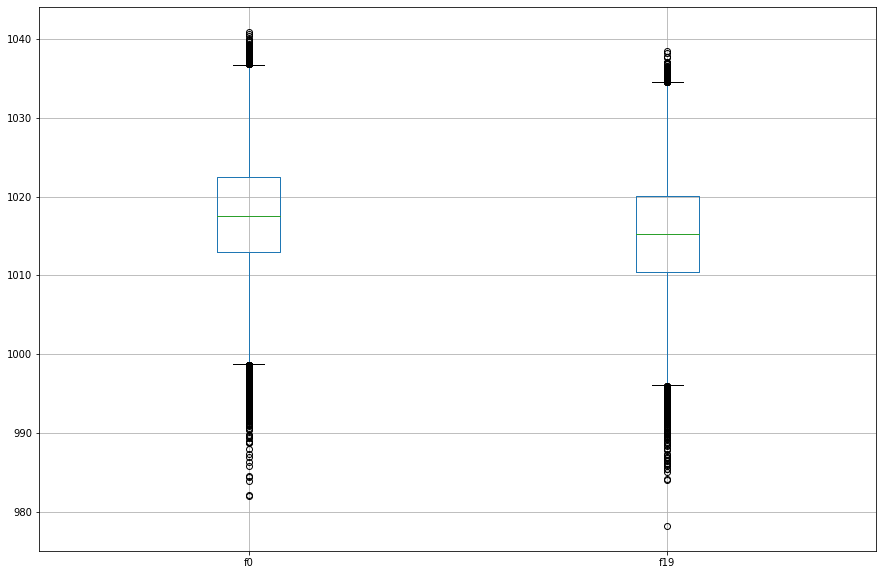

In [232]:
X_train.boxplot(['f0', 'f19'], figsize=(15,10))

<AxesSubplot:>

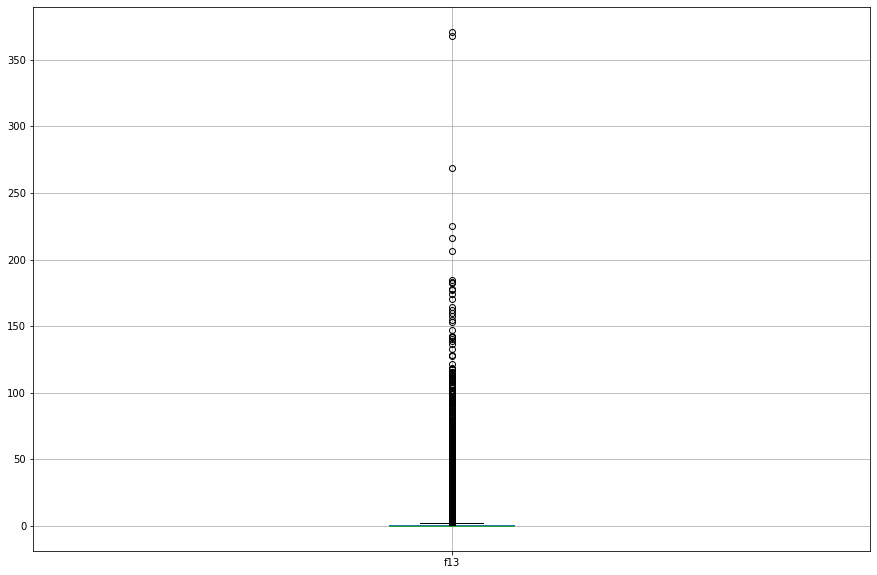

In [234]:
X_train.boxplot('f13', figsize=(15,10))

<AxesSubplot:>

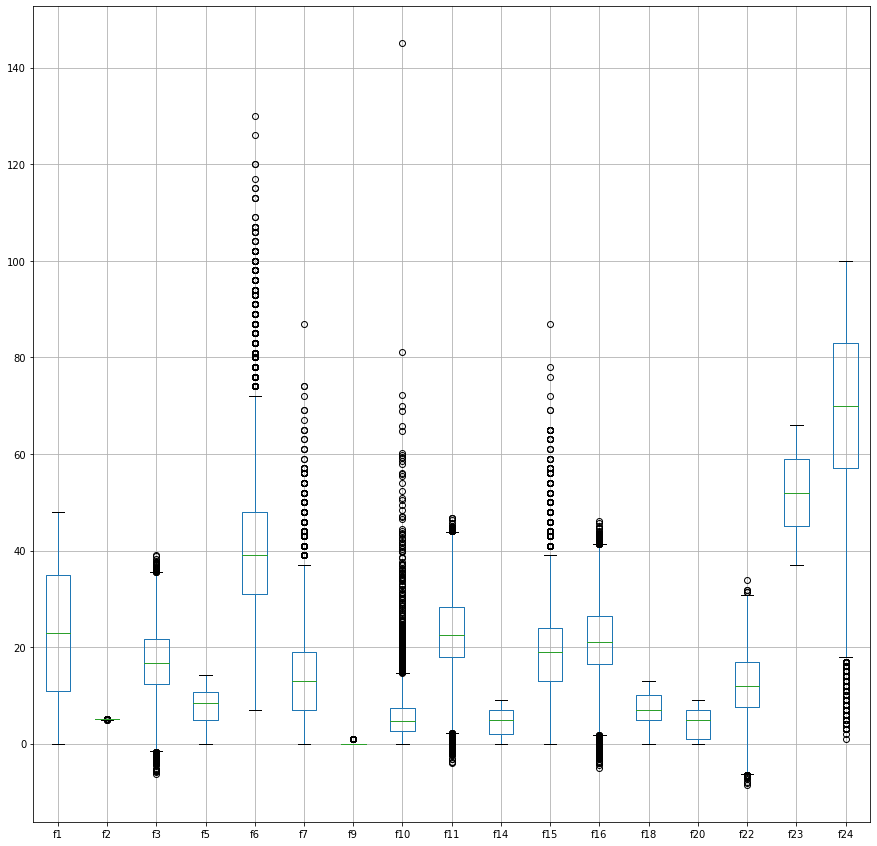

In [233]:
X_train.boxplot([x for x in X_train.drop(['f0', 'f19', 'f4', 'f8', 'f12', 'f17', 'f21', 'f13'], axis=1).columns], figsize=(15,15))

There are some outliers we can clearly see in this data.

## Find duplicates

Are there any exact duplicates of samples in the data? If there are, this might hurt the model's ability to generalize as it will "learn more" from the duplicated data.

In [ ]:
X_train.duplicated().apply(lambda x: x is True).sum()

No duplicates. Great!

# Preprocessing the data

## Remove outliers

In [302]:
def find_skew(x):
    tmp=x.dropna()
    skew_value=skew(tmp)
    return 'sample lengh: %s   and skew: %s'%(len(tmp),skew_value)

Lets find the skew value for the features with obvious putliers, and try to lower it.

In [303]:
def print_skews():
    exclude = cat_cols + [hex_col]
    for col in X_train.drop(exclude, axis=1).columns:
        print(col, ': ', find_skew(X_train[col]))
        
print_skews()

f0 :  sample lengh: 45122   and skew: -0.08942690721996308
f1 :  sample lengh: 50000   and skew: 0.041465316694681204
f2 :  sample lengh: 48816   and skew: -0.14545019903223808
f3 :  sample lengh: 49677   and skew: 0.0775877961513525
f5 :  sample lengh: 26130   and skew: -0.5021855879232536
f6 :  sample lengh: 46648   and skew: 0.8630224707440753
f7 :  sample lengh: 49517   and skew: 0.7790643885914641
f9 :  sample lengh: 49497   and skew: 1.3318613270813682
f10 :  sample lengh: 28585   and skew: 4.512699109189178
f11 :  sample lengh: 49894   and skew: 0.21785047803962587
f13 :  sample lengh: 49497   and skew: 11.05542172973073
f14 :  sample lengh: 29937   and skew: -0.2295300544803834
f15 :  sample lengh: 49057   and skew: 0.6330558503818273
f16 :  sample lengh: 49020   and skew: 0.23634685216381526
f18 :  sample lengh: 48749   and skew: -0.2849660835833031
f19 :  sample lengh: 45121   and skew: -0.04659824449732003
f20 :  sample lengh: 31245   and skew: -0.21569917298204225
f22 :  sa

We know f9 is a binary value, so it is expected to be a little "askew". Let's try to improve the skew value of f10 and f13 without losing too many samples

In [301]:
X_train_outliers = X_train[train.f10<62]
find_skew(X_train_outliers['f10'])

'sample lengh: 28578   and skew: 2.890565628955878'

In [309]:
X_train_outliers = X_train[train.f13<200]
find_skew(X_train_outliers.f13)

'sample lengh: 49491   and skew: 8.181385154078031'

In [311]:
X_train = X_train_outliers
print_skews()

f0 :  sample lengh: 44701   and skew: -0.09124577396554001
f1 :  sample lengh: 49491   and skew: 0.04138856417128502
f2 :  sample lengh: 48317   and skew: -0.14486430367399583
f3 :  sample lengh: 49249   and skew: 0.07828570723437252
f5 :  sample lengh: 25978   and skew: -0.5053998664983167
f6 :  sample lengh: 46207   and skew: 0.8621140077344968
f7 :  sample lengh: 49100   and skew: 0.7794673962476725
f9 :  sample lengh: 49491   and skew: 1.3325150446780893
f10 :  sample lengh: 28495   and skew: 4.517119917036553
f11 :  sample lengh: 49392   and skew: 0.22368351745782433
f13 :  sample lengh: 49491   and skew: 8.181385154078031
f14 :  sample lengh: 29776   and skew: -0.22753433266819353
f15 :  sample lengh: 48581   and skew: 0.6340531265608168
f16 :  sample lengh: 48545   and skew: 0.2409706922324196
f18 :  sample lengh: 48254   and skew: -0.284266362029079
f19 :  sample lengh: 44687   and skew: -0.04884789720627165
f20 :  sample lengh: 31096   and skew: -0.21305656319020622
f22 :  sam

## Encode features

We need to One Hot Encode the categorical data, and also convert the hex values to decimal numbers

In [312]:
X_train_encoded = X_train

for i in cat_cols:
    X_train_encoded = pd.concat([X_train, pd.get_dummies(X_train[i], prefix=i)],axis=1)
    X_train_encoded.drop([i],axis=1, inplace=True)

In [313]:
X_train_encoded.head()

f0  f1      f2    f3   f4    f5    f6    f7 f8   f9  ...  f21_dbd  \
0  1013.1   0  5.0190  26.1  bbd  11.1  33.0  11.0  m  0.0  ...        0   
1  1010.2   1  5.0142  10.4    n   NaN  46.0  17.0  k  0.0  ...        0   
2  1014.4   2  5.0280  12.3  xnx   NaN  31.0  13.0  c  1.0  ...        0   
3  1019.2   3  5.0335  23.0   nx  11.6  41.0   9.0  i  0.0  ...        0   
4  1027.6   4  5.0129   7.3    d   7.3  28.0  15.0  h  1.0  ...        1   

   f21_dnd f21_n  f21_nd  f21_nnd  f21_nnx  f21_nx f21_x  f21_xbx  f21_xnx  
0        0     0       1        0        0       0     0        0        0  
1        0     0       0        0        0       1     0        0        0  
2        0     0       0        0        0       1     0        0        0  
3        1     0       0        0        0       0     0        0        0  
4        0     0       0        0        0       0     0        0        0  

[5 rows x 40 columns]

In [314]:
X_test_encoded = X_test

for i in cat_cols:
    X_test_encoded = pd.concat([X_test, pd.get_dummies(X_test[i], prefix=i)],axis=1)
    X_test_encoded.drop([i],axis=1, inplace=True)

In [315]:
X_test_encoded.head()

f0  f1      f2    f3   f4    f5    f6    f7 f8   f9  ...  f21_dbd  \
0  1024.4  15  5.0256   6.6  xbx   0.8  20.0   2.0  o  0.0  ...        0   
1  1029.0   3  5.0289   5.6   nx   9.0  28.0   0.0  h  0.0  ...        0   
2  1016.7  10  5.0081  22.3    d   NaN  31.0   6.0  k  0.0  ...        0   
3  1009.3  33  5.0168  11.3   bd   NaN  31.0  11.0  a  1.0  ...        0   
4  1027.1  37  5.0205  12.6   bx  12.6  22.0   6.0  d  0.0  ...        0   

   f21_dnd f21_n  f21_nd  f21_nnd  f21_nnx  f21_nx f21_x  f21_xbx  f21_xnx  
0        0     0       0        0        0       0     0        0        0  
1        0     0       0        0        0       0     0        0        0  
2        0     0       0        0        0       0     0        0        0  
3        1     0       0        0        0       0     0        0        0  
4        0     0       0        0        0       0     0        0        0  

[5 rows x 40 columns]

In [316]:
X_train_encoded['f12_dec'] = X_train[hex_col].dropna().astype(str).apply(lambda x: int(x, 16))
X_test_encoded['f12_dec'] = X_test[hex_col].dropna().astype(str).apply(lambda x: int(x, 16))

In [317]:
X_train_encoded.drop([hex_col],axis=1, inplace=True)
X_test_encoded.drop([hex_col],axis=1, inplace=True)

In [318]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      44701 non-null  float64
 1   f1      49491 non-null  int64  
 2   f2      48317 non-null  float64
 3   f3      49249 non-null  float64
 4   f4      46180 non-null  object 
 5   f5      25978 non-null  float64
 6   f6      46207 non-null  float64
 7   f7      49100 non-null  float64
 8   f8      48050 non-null  object 
 9   f9      49491 non-null  float64
 10  f10     28495 non-null  float64
 11  f11     49392 non-null  float64
 12  f12     47989 non-null  object 
 13  f13     49491 non-null  float64
 14  f14     29776 non-null  float64
 15  f15     48581 non-null  float64
 16  f16     48545 non-null  float64
 17  f17     48160 non-null  object 
 18  f18     48254 non-null  float64
 19  f19     44687 non-null  float64
 20  f20     31096 non-null  float64
 21  f21     46018 non-null  object 
 22

In [319]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       44701 non-null  float64
 1   f1       49491 non-null  int64  
 2   f2       48317 non-null  float64
 3   f3       49249 non-null  float64
 4   f4       46180 non-null  object 
 5   f5       25978 non-null  float64
 6   f6       46207 non-null  float64
 7   f7       49100 non-null  float64
 8   f8       48050 non-null  object 
 9   f9       49491 non-null  float64
 10  f10      28495 non-null  float64
 11  f11      49392 non-null  float64
 12  f13      49491 non-null  float64
 13  f14      29776 non-null  float64
 14  f15      48581 non-null  float64
 15  f16      48545 non-null  float64
 16  f17      48160 non-null  object 
 17  f18      48254 non-null  float64
 18  f19      44687 non-null  float64
 19  f20      31096 non-null  float64
 20  f22      49302 non-null  float64
 21  f23      249

### Removing null values

For ML methods that do not handle Null values, we need to iumpute the value of missing values in the data.

For the XGBoost algorithm, we do not need to remove the null variables as these will be handled as "missing". However, for other algorithms we might need to imputate them from other data points.

In [11]:
#for col in X_train.columns:
#    values = X_train[col]
#    if values.dtype in ['int', 'float']:
#        values_mean = values.mean()
#        values.fillna(values_mean, inplace=True)

#X_train.isnull().sum()

### Remove duplicate rows

We already established that there are no duplicates in the data, but if there were, we could drop them by running:

In [9]:
X_train_encoded = X_train_encoded.drop_duplicates()
X_train_encoded.shape

(50000, 25)

We did, however, have some redundant features. For the features with a , I will feature with the least samples

### f0 and f19

# Save the data to csv files

In [27]:
X_train_encoded.to_csv('data/prepared_train_data.csv')

In [28]:
X_test_encoded.to_csv('data/prepared_test_data.csv')

# Create a model and predict

## xgboost.XGBClassifier from scikit-learn

In [29]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_tr, X_te, y_tr, y_te = train_test_split(X_train, Y_train, test_size=test_size, random_state=seed)

In [30]:
# fit model no training data
model = XGBClassifier(eta=0.2, max_depth=10, objective='multi:softprob', booster='gbtree', num_class=2)
model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
pred1 = model.predict(X_test)
id_pred1 = pd.DataFrame({'sample_id': train['id'], 'prediction_in_probability': pred1})
id_pred1.head(20)

sample_id  prediction_in_probability
0           0                          0
1           1                          0
2           2                          0
3           3                          1
4           4                          0
5           5                          0
6           6                          0
7           7                          0
8           8                          0
9           9                          0
10         10                          0
11         11                          0
12         12                          0
13         13                          0
14         14                          0
15         15                          0
16         16                          0
17         17                          0
18         18                          0
19         19                          0

In [32]:
# make predictions for test data
y_pred = model.predict(X_te)
predictions = [round(value) for value in y_pred]

# Analyze model

In [33]:
# evaluate predictions
accuracy = accuracy_score(y_te, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.78%


In [34]:
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 84.76% (0.58%)


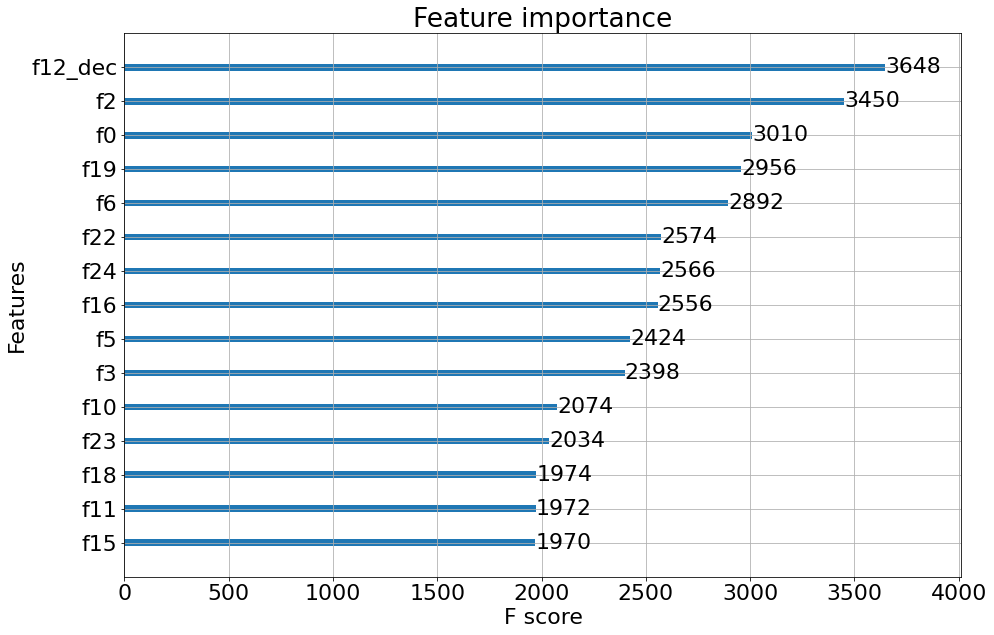

In [35]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 22})
rcParams['figure.figsize'] = 15,10

xgb.plot_importance(model, max_num_features=15)
pyplot.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.312997 to fit


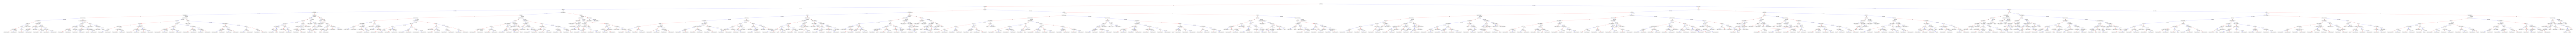

In [37]:
rcParams['figure.figsize'] = 100,100
xgb.plot_tree(model)
pyplot.show()

In [ ]:
model.save_model('xgboost_model.json')